## Annotation Types
* This is a common format for representing human and machine generated annotations
* A standard interface allows us to build tools to simplify ml workflows
* Currently the interfaces support images, text, and video. Tiled imagery is not available yet.
* The interfaces are designed to represent data for machine learning models.
This means that you can use them without using labelbox or having references to labelbox objects. 
Functions for connecting annotations to labelbox are provided.

In [ ]:
!pip install labelbox[data]

In [65]:
# Import basic data
from labelbox.data.annotation_types import (
    LabelCollection,
    Label,
    RasterData,
    TextData,
    VideoData,
    ObjectAnnotation,
    ClassificationAnnotation,    
    Polygon,
    Rectangle,
    Line,
    Mask,
    Point,
    Checklist,
    Radio,
    Text,
    TextEntity,
    ClassificationAnswer
)

import requests
import IPython
from PIL import Image
from io import BytesIO
import numpy as np
from shapely.ops import transform
from shapely.affinity import affine_transform
from labelbox import LabelingFrontend, Client, OntologyBuilder, Tool, Classification, Option

In [ ]:
# If you don't want to give google access to drive you can skip this cell
# and manually set `API_KEY` below.

if COLAB:
    !pip install colab-env -qU
    from colab_env import envvar_handler
    envvar_handler.envload()

API_KEY = os.environ.get("LABELBOX_API_KEY")
if not os.environ.get("LABELBOX_API_KEY"):
    API_KEY = getpass("Please enter your labelbox api key")
    if COLAB:
        envvar_handler.add_env("LABELBOX_API_KEY", API_KEY)

In [ ]:
# Only update this if you have an on-prem deployment
ENDPOINT = "https://api.labelbox.com/graphql"

client = Client(api_key=API_KEY, endpoint=ENDPOINT)

### Basic Example
* A Label contains:
    1. Data
    2. Annotations associated with that data
* The individual components will be explained below

In [2]:
label = Label(
    data = RasterData(url = "http://my-img.jpg"),
    annotations = [
        ObjectAnnotation(
            value = Point(x = 10, y = 10),
            name = "target"
        )
    ]
)

* All models are pydantic so we can easily convert all of our objects to dictionaries and view the schema.

In [3]:
label.schema()
label.dict()

{'data': {'external_id': None,
  'uid': None,
  'im_bytes': None,
  'file_path': None,
  'url': 'http://my-img.jpg',
  'arr': None},
 'annotations': [{'name': 'target',
   'schema_id': None,
   'extra': {},
   'value': {'extra': {}, 'x': 10.0, 'y': 10.0},
   'classifications': []}],
 'extra': {}}

# Data 
* There are three classes to represent data
    * TextData
    * VideoData
    * RasterData
* The data objects can be constructed from various representations
    - remote (url, uri)
    - disk ( file path)
    - compressed (image bytes)
    - memory ( numpy array, 
* Then the access pattern is consistent regardless of the format used to construct the object


### RasterData

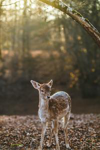

In [4]:
# Data can be instantiated with any of the following
image = RasterData(im_bytes = b'bytes')
image = RasterData(arr = np.zeros((10,10)).astype(np.uint8))
image = RasterData(file_path = '/tmp/img.jpg')
image_url = "https://picsum.photos/id/1003/200/300"
image = RasterData(url = image_url)
# All of these can access the numpy representation the same way:
np_data = image.data


im = Image.fromarray(np_data)
im.resize((im.size[0]//2, im.size[1]//2))

### TextData

In [5]:
# Text has the same access pattern as imagery.
text = TextData(file_path = "/tmp/some local file.txt")
text = TextData(text = " some text content...")
text = TextData(url = "https://filesamples.com/samples/document/txt/sample3.txt")

print(text.data[:100])

Quod equidem non reprehendo;
Lorem ipsum dolor sit amet, consectetur adipiscing elit. Quibus natura 


### VideoData

In [6]:
video_url = "http://commondatastorage.googleapis.com/gtv-videos-bucket/sample/ForBiggerMeltdowns.mp4"

video = VideoData(file_path = "some video path.mp4")
video = VideoData(frames = { 1: np.zeros((32, 32, 3), dtype = np.uint8)})
video = VideoData(url=video_url)


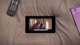

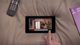

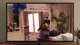

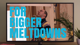

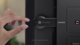

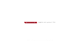

In [7]:

for idx, frame in video.data:
    # Show every 50th frame
    if idx % 50 == 0:
        video_im = Image.fromarray(frame)
        w,h = video_im.size
        IPython.display.display( video_im.resize((w//16, h//16) ))        
    if idx > 250:
        break



### Advanced

#### Adding data row information
* This is not required ( and can be added at a later time but you can add data row information to your data)


In [8]:
td = TextData(text = "some text", uid = "ckrey6o07000008l50uk2gcr3", external_id = "my_text_data_row")
rd = RasterData(url = image_url, uid = "ckrey7te2000108l5hl8564dr", external_id = "my_raster_data_row")
vd = VideoData(url = video_url, uid = "ckrey7xef000208l57hwfgi3v", external_id = "my_video_data_row")

#### Non-public urls
* If the urls in your data is not publicly accessible you can override the fetching logic
* For TextData and ImageData overwrite the following function and make sure it has the same signature. `data.fetch_remote(self) -> bytes`.
* For VideoData, the signature is `VideoData.fetch_remote(self, local_path)`. This function needs to download the video file locally to that local_path to work.

In [9]:
image.set_fetch_fn(lambda self: requests.get(self.url, headers = {...}).content)

AttributeError: 'RasterData' object has no attribute 'set_fetch_fn'

# Annotations

* There are 4 types of annotations
    1. ObjectAnnotation
        - Objects with location information
        - Annotations that are found in the object field of the labelbox export
        - Classes: Point, Polygon, Mask, Line, Rectangle, Named Entity
    2. ClassificationAnnotation
        - Classifications that can apply to data or another annotation
        - Classes: Checklist, Radio, Text, Dropdown
    3. VideoObjectAnnotation
        - Same as object annotation but there are extra fields for video information
    4. VideoClassificationAnnotation
        - Same as classification annotation but there are extra fields for video information    
-------- 
* Create an annotation by providing the following:
1. Value
    - Must be either a Geometry, TextEntity, or Classification
    - This is the same as a top level tool in labelbox
2. name or schema_id
    - This is the id that corresponds to a particular class or just simply the class name
    - If uploading to labelbox this must match a field in an ontology.
3. (Optional) Classifications 
    - List of ClassificationAnnotations. This self referencing field enables infinite nesting of classifications.
    - Be careful with how you use the tool. Labelbox does not support nesting classifications
    - E.g. you can have tool.classifications but not tool.classifications[0].classifications
        

### ObjectAnnotation

##### Point

In [10]:
point_annotation = ObjectAnnotation(
    value = Point(x = 5, y = 3),
    name = "point class name"
)

point_annotation = ObjectAnnotation(
    value = Point(x = 5, y = 3),
    schema_id = "ckrgcgl89000108jtggc9e687"
)

##### Polygon

In [11]:
# Given some polygon:
xy_poly = [
    [60, 161], [67, 177], [76, 180], [77, 222], [82, 246], [78, 291], [72, 300], [87, 300], 
    [94, 244], [103, 243], [100, 269], [90, 290], [95, 296], [104, 292], [108, 272], 
    [111, 300], [121, 300], [117, 244], [128, 236], [133, 298], [142, 297], [137, 250], 
    [146, 208], [138, 185], [120, 180], [105, 189], [112, 162], [93, 156], [72, 160], 
]

polygon_annotation = ObjectAnnotation(
        value = Polygon(points = [Point(x = x, y = y) for x,y in xy_poly]),
            name = "polygon class name"
)

polygon_annotation = ObjectAnnotation(
        value = Polygon(points = [Point(x = x, y = y) for x,y in xy_poly]),
            schema_id = "ckrgcel71000008jtd9mn0szu"
)



##### Line

In [12]:
xy_line = [[0,0], [10,5], [15,5]]

line_annotation = ObjectAnnotation(
        value = Line(points = [Point(x = x, y = y) for x,y in xy_line]),
            name = "line class name"
)

line_annotation = ObjectAnnotation(
        value = Line(points = [Point(x = x, y = y) for x,y in xy_line]),
            schema_id = "ckrgcel71000008jtd9mn0szu"
)

##### Rectangle

In [13]:
start = Point(x = 0, y = 0)
end = Point(x = 5, y = 10)

rectangle_annotation = ObjectAnnotation(
        value = Rectangle(start = start, end = end),
            name = "rectangle class name"
)

rectangle_annotation = ObjectAnnotation(
        value = Rectangle(start = start, end = end),
            schema_id = "ckrgcel71000008jtd9mn0szu"
)

##### Mask
* The mask can be any RasterData object.


In [14]:

mask_annotation = ObjectAnnotation(
        value = Mask(mask =  RasterData(arr = np.zeros((32,32,3), dtype = np.uint8)), color = 255),
            name = "mask class name"
)

mask_annotation = ObjectAnnotation(
        value = Mask(mask =  RasterData(arr = np.zeros((32,32,3), dtype = np.uint8)), color = 255),
            schema_id = "ckrgcel71000008jtd9mn0szu"
)

* Multiple mask objects can reference the same mask to save memory and reduce the number of files that need to be uploaded (i.e. one seg mask for multiple classes).



In [15]:
raster_data = RasterData(arr = np.zeros((32,32,3), dtype = np.uint8))
mask_annotation = ObjectAnnotation(
        value = Mask(mask  = raster_data, color = [255,255,255]),
            name = "eyes"
)

mask_annotation = ObjectAnnotation(
        value = Mask(mask = raster_data, color = [0,255,255]),
            name = "nose"
)

* The Mask class support either RGB or Grayscale masks
* Grayscale masks must have a single color.

In [16]:
raster_data = RasterData(arr = np.zeros((32,32), dtype = np.uint8))
mask_annotation = ObjectAnnotation(
        value = Mask(mask  = raster_data, color = 128),
            name = "eye"
)

mask_annotation = ObjectAnnotation(
        value = Mask(mask = raster_data, color = 255),
            name = "nose"
)

##### Text Entity

In [17]:

entity_annotation = ObjectAnnotation(
        value = TextEntity(start  = 10, end = 12),
            name = "person"
)

entity_annotation = ObjectAnnotation(
        value = TextEntity(start  = 10, end = 12),
            schema_id = "ckrgddyli000108mk0c0t9qya"
)

##### Geometry Utilities
* All of the previous objects except TextEntity inherit from the Geometry base class
* They have the following properties and functions
    1. raster(height width, kwargs)
    2. shape - property
    3. geometry - property

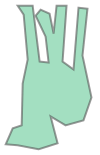

In [18]:
polygon_annotation.value.shapely

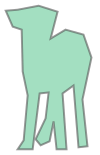

In [19]:
def flip_y_axis(poly, height):
    return affine_transform(poly,[1, 0, 0, -1, 0, height])

flip_y_axis(polygon_annotation.value.shapely, im.size[1])

##### Shape to Mask

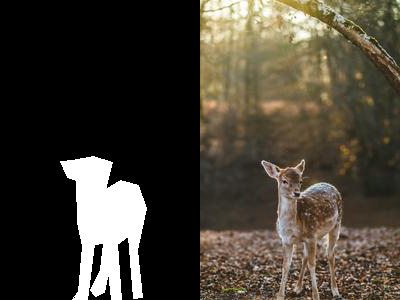

In [20]:
color = 255
np_mask = polygon_annotation.value.raster(height = im.size[1], width = im.size[0], color = color)
Image.fromarray(np.hstack([np.stack((np_mask,)*3, axis=-1), np_data]))

##### Mask to Shape
* Adds extra vertices to be as accurate as possible

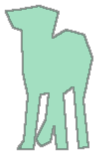

In [21]:
mask_annotation = Mask(
    mask = RasterData(arr = np_mask),
    color = color 
)

flip_y_axis(mask_annotation.shapely, im.size[1])
# Simplify with mask_annotation.shapely.simplify(<float> simplification error tolerance)

#### Masks with multiple annotations
* Since masks can contain multiple classes you can split them up by calling raster on an individual annotation.
* E.g. eyes and nose for our deer image

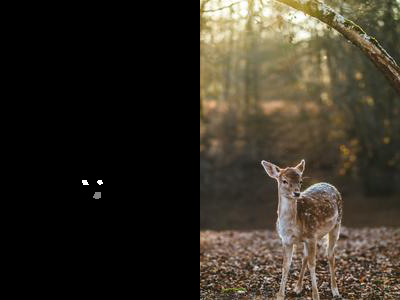

In [22]:
# Build a combined mask from polygons
eye_color, nose_color = 255, 128
h,w = np_data.shape[:2]
eyes = [
    Polygon(points = [Point(x=x,y=y) for x,y in [[82, 180], [83, 184], [88, 184], [86, 180]]]),
    Polygon(points = [Point(x=x,y=y) for x,y in [[97, 182], [99, 184], [102, 183], [101, 180], [98, 180]]]),    
]
eye_masks = np.max([eye.raster(height = h, width = w) for eye in eyes], axis = 0)
nose = Polygon(points =[ Point(x=x,y=y) for x,y in [[95, 192], [93, 197], [96, 198], [100, 197], [100, 194], [100, 192], [96, 192]]])
nose_mask = nose.raster(height = h, width = w, color = nose_color)
# Picks the brighter color if there is overlap. 
# If you don't want overlap then just simply create separate masks
np_seg_mask = np.max([nose_mask, eye_masks], axis = 0)
Image.fromarray(np.hstack([np.stack((np_seg_mask,)*3, axis=-1), np_data]))

* Create two mask annotations from this one image

In [44]:
mask_data = RasterData(arr = np_seg_mask)
eye_mask = Mask(mask = mask_data, color = eye_color)
nose_mask = Mask(mask = mask_data, color = nose_color)


* Calling `mask.raster()` will return a mask with pixels equal to the specified color

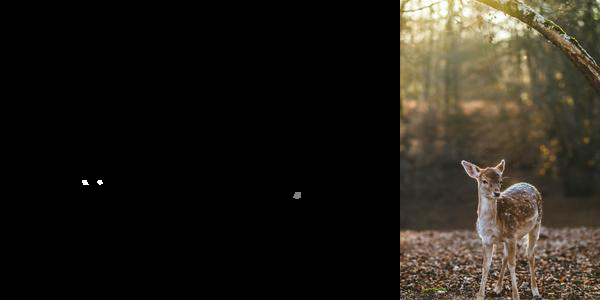

In [45]:
eye_raster = eye_mask.raster()
nose_raster = nose_mask.raster()
Image.fromarray(np.hstack([np.stack((eye_raster,)*3, axis=-1),np.stack((nose_raster,)*3, axis=-1), np_data]))

### Classification Annotation

#### Text

In [46]:
text_annotation = ClassificationAnnotation(
    name = "my text class", 
    value = Text(answer = "some text answer")                               
)

text_annotation = ClassificationAnnotation(
    schema_id = "my text class", 
    value = Text(answer = "some text answer")                               
)

#### Radio

In [47]:
radio_annotation = ClassificationAnnotation(
    name = "is dog",
    value = Radio(answer = ClassificationAnswer(name = "dog")) 
)


radio_annotation = ClassificationAnnotation(
    schema_id = "ckresqdg7000001jnb70v4zcc",
    value = Radio(answer = ClassificationAnswer(schema_id = "ckrdy06ia000007ky94h04qlj")) 
)

##### Checklist

In [48]:

checklist_annotation = ClassificationAnnotation(
    schema_id = "ckrestd5g000101jnhudjf29a",
    value = Checklist(answer = [ClassificationAnswer(schema_id = "ckrdy06ia000007ky94h04qlj")])
)
                                
checklist_annotation = ClassificationAnnotation(
    name = "weather",
    value = Checklist(answer = [ClassificationAnswer(name = "cloudy")]) 
)

### Subclassifications
* Objects can have nested classifications

In [49]:
subclass_annotation = ObjectAnnotation(
    value = Polygon(points = [Point(x = x, y = y) for x,y in xy_poly]),
    name = "deer",
    classifications = [
        checklist_annotation, radio_annotation
    ]
)

# Labels
* Labels connect a list of annotations to data such as images, text, and video.
* Labels have a convenient set of functions for dealing with that collection of data

In [50]:
label = Label(
    data = RasterData(url = image_url),
    annotations = [
        ObjectAnnotation(
            value = Polygon(points = [Point(x = x, y = y) for x,y in xy_poly]),
            name = "deer"
        ),
        ObjectAnnotation(
            name = "deer_eyes",
            value = Mask(mask = RasterData(arr = np_mask), color = color)
        )
    ]
)

### Interacting with labelbox:
* For this label to be compatible with labelbox we need the following:
    - all named features must have schema_ids
    - all data must have urls
        - masks
        - images
        - videos
        - text
    

### Uploading Urls
* It doesn't matter how urls are set
* Manually setting urls or use helper functions are both valid for working with labelbox

In [52]:
# Manually set just by adding a value:
image = RasterData(arr = np_data)
image.url = "http://myurl"

* Use functions to upload urls:
    - Upload image urls : `Label.add_url_to_data(signer)`
    - Upload segmentation masks : `label.add_url_to_masks(signer)`

----- 
* Define the signer
    - Creating urls requires a function that maps bytes to a str (url)

In [53]:
def signing_function(obj_bytes: bytes) -> str:
    # WARNING: Do not use this signer. You will not be able to resign these images at a later date
    url = client.upload_data(content=obj_bytes, sign=True)
    return url

* Create a complex label

In [54]:

label = Label(
    data = RasterData(arr = np_data),
    annotations = [
         ObjectAnnotation(
            name = "deer_nose",
            value = nose_mask,
            classifications = [
                ClassificationAnnotation(
                    name = "description",
                    value = Radio(
                        answer = ClassificationAnswer(name = "wet")
                    )
                )
            ]
        ),
        ObjectAnnotation(
            name = "deer_eyes",
            value = eye_mask
        ),
        ObjectAnnotation(
            value = Polygon(points = [Point(x = x, y = y) for x,y in xy_poly]),
            name = "deer"
        ),
        ClassificationAnnotation(name = "image_description", 
            value = Checklist(answer = [
                ClassificationAnswer(name = "bright"),
                ClassificationAnswer(name = "not_blurry"),            
         ])),
    ]
)

* Check that the image does not have a url
* Add the url
* Check that the url was added

In [55]:
print("Before",label.data.url)
label.add_url_to_data(signing_function)
print("After", label.data.url)

Before None
After https://storage.labelbox.com/ckqcx1czn06830y61gh9v02cs%2F958abb1f-f29a-08e3-906d-38bc72f9c88d-1?Expires=1627142391907&KeyName=labelbox-assets-key-3&Signature=2d45A4n3RxUIdJ8_cnlgcaZTZcA


* Masks also need urls for annotation imports
* Note that the url is the same when uploaded.
    - The url is only uploaded once

In [56]:
# We also have a mask that needs a url:
mask_annotations = [annot for annot in label.annotations if isinstance(annot.value, Mask)]
for annot in mask_annotations:
    print(f"{annot.name} before" , annot.value.mask.url)
    
    
label.add_url_to_masks(signing_function)


for annot in mask_annotations:
    print(f"{annot.name} after" , annot.value.mask.url)

deer_nose before None
deer_eyes before None
deer_nose after https://storage.labelbox.com/ckqcx1czn06830y61gh9v02cs%2Fe64fb293-9380-6ecc-525e-d2c277bd0da5-1?Expires=1627142393623&KeyName=labelbox-assets-key-3&Signature=dvW5VxFzrb-I37uiYIscV-c_7mo
deer_eyes after https://storage.labelbox.com/ckqcx1czn06830y61gh9v02cs%2Fe64fb293-9380-6ecc-525e-d2c277bd0da5-1?Expires=1627142393623&KeyName=labelbox-assets-key-3&Signature=dvW5VxFzrb-I37uiYIscV-c_7mo


### Creating Data Rows
* Our Labels objects are great for working with locally but we might want to upload to labelbox
* This is required for MAL, MEA, and to add additional labels to the data.


In [57]:
dataset = client.create_dataset(name = "label_dataset")

In [58]:
# Note that the signing function is only used if a url is not already provided
print(label.data.uid)
label.create_data_row(dataset, signing_function)
print(label.data.uid)

None
ckrgj4y4q6mpi0y78gvu1ax9w


### Assigning Schema Ids:
* All tools, classifications, and options either have names or schema_ids.
* Locally it is convenient to provide a name so that we don't need a labelbox project to use these interfaces.
* To use MAL and MEA schema ids are required

In [59]:
# When uploading for MAL or MEA we need an ontology.
# So let's create one




# These names have to match our object names exactly!!
ontology_builder = OntologyBuilder(tools=[
    Tool(tool=Tool.Type.POLYGON, name="deer"),
    Tool(tool=Tool.Type.SEGMENTATION, name="deer_nose", 
         classifications = [
             Classification(
                 class_type = Classification.Type.RADIO, 
                 instructions = "description", 
                 options = [Option(value = "wet")]
             )]),
    Tool(tool=Tool.Type.SEGMENTATION, name="deer_eyes")    
], classifications = [
    Classification(
        Classification.Type.CHECKLIST, 
        instructions = "image_description", 
        options = [Option(value = "bright"), Option(value = "not_blurry"), Option(value = "dark")])])


editor = next(
    client.get_labeling_frontends(where=LabelingFrontend.name == "Editor"))
project = client.create_project(name="test_annotation_types")
project.setup(editor, ontology_builder.asdict())
project.datasets.connect(dataset)

ontology = OntologyBuilder.from_project(project)

In [61]:
def show_schema_ids(label):
    for annotation in label.annotations:
        print(f"Object : {annotation.name} - {annotation.schema_id}")
        for classification in getattr(annotation, 'classifications', []):
            print(f"--- Subclass : {classification.name} - {classification.schema_id}")
            option = classification.value
            print(f"--- --- Options: {option.answer.name} - {option.answer.schema_id}")

        if isinstance(annotation, ClassificationAnnotation):
            for option in annotation.value.answer:
                print(f"--- Options: {option.name} - {option.schema_id}")
show_schema_ids(label)

Object : deer_nose - None
--- Subclass : description - None
--- --- Options: wet - None
Object : deer_eyes - None
Object : deer - None
Object : image_description - None
--- Options: bright - None
--- Options: not_blurry - None


In [62]:
label.assign_schema_ids(ontology)
show_schema_ids(label)

Object : deer_nose - ckrgj510sbza30y8dd98tfsjt
--- Subclass : description - ckrgj511jbzad0y8dgajh3gve
--- --- Options: wet - ckrgj5124bzaf0y8dc4ef1y7f
Object : deer_eyes - ckrgj510sbza50y8d2wv22fsq
Object : deer - ckrgj510rbza10y8d412lezud
Object : image_description - ckrgj510rbz9z0y8deaf2b34s
--- Options: bright - ckrgj511dbza70y8ddb4ndumo
--- Options: not_blurry - ckrgj511dbza90y8dhe1bhmbp


### Next Steps
* Annotation types should be thought of as low level interfaces
* We are working on a set of tools to make most of what is covered in this notebook happen behind the scenes
* Checkout other notebooks to see how to use higher level tools that are compatible with these interfaces

In [63]:
# Cleanup
dataset.delete()
project.delete()